# Installs & tokens

In [2]:
%%capture
try:
    import mlflow
except ImportError:
    !pip install mlflow

In [3]:
%%capture
try:
    import dotenv
except ImportError:
    !pip install python-dotenv

In [4]:
# # Log into huggingface via Kaggle Secrets

# import os
# import huggingface_hub
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
# HF_TOKEN = user_secrets.get_secret("HF_TOKEN")

# huggingface_hub.login(token=HF_TOKEN)

In [5]:
# # Log into huggingface via .env

# import os
# from dotenv import load_dotenv
# import huggingface_hub

# load_dotenv()

# HF_TOKEN = os.getenv("HF_TOKEN")
# huggingface_hub.login(token=HF_TOKEN)

# Choose notebook parameters

In [ ]:
import torch

## CHOOSE MODEL PARAMETERS #################################################

MODEL_NAME_POSTFIX='splitting-by-query'
NAME_MODEL_NAME = 'cointegrated/rubert-tiny' # 'DeepPavlov/distilrubert-tiny-cased-conversational-v1'
DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny'

DATA_PATH = 'data/'
RESULTS_DIR = 'train_results/'

# BATCH_SIZE=60 # uses 14.5GiB of 1 GPU
# NUM_WORKERS=2 # TODO: use multiple GPU, tune number of workers
# NUM_DEBUG_SAMPLES=None
# EPOCHS=10 # epochs > 8 => overfit; NOTE: can train for longer since we take best validation checkpoint anyway

BATCH_SIZE=1
NUM_WORKERS=0
NUM_DEBUG_SAMPLES=2
EPOCHS=2

PRELOAD_MODEL_NAME = 'cc12m_rubert_tiny_ep_1.pt' # preload ruclip
# PRELOAD_MODEL_NAME = None

VALIDATION_SPLIT=.05
TEST_SPLIT=.1
RANDOM_SEED=42
LR=9e-5
MOMENTUM=0.9
WEIGHT_DECAY=1e-2
CONTRASTIVE_MARGIN=1.5
CONTRASTIVE_THRESHOLD=0.3
SHEDULER_PATIENCE=3 # in epochs

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
## CHOOSE DATA #########################################################

# # These table files need 'image_name_first', 'image_name_second' constructed from sku to be usable in current pipeline
# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_1.3k_with-options.csv'
# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_56k_with-options.csv'
# IMG_DATASET_NAME = 'images_7k'
# STRATIFY_COLS = None

# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_5k_with-options.csv'
# IMG_DATASET_NAME = 'images_7k' 
# STRATIFY_COLS = None

# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated_shuffled_seed=42_fraction=1.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated_shuffled_seed=42_fraction=0.5.csv'
# IMG_DATASET_NAME = 'images_WB_OZ_100'
# STRATIFY_COLS = None

TABLE_DATASET_FILE = 'tables_OZ_geo_5500/processed/regex-pairwise-dataset_num-queries=20_num-pairs=6226_patterns-dict-hash=6dbf9b3ef9568e60cd959f87be7e3b26.csv'
IMG_DATASET_NAME = 'images_OZ_geo_5500'
STRATIFY_COLS = ['sku_first', 'label']

In [8]:
## LOGGING PARAMS ######################################################################

# MLFLOW_URI = "http://176.56.185.96:5000"
# MLFLOW_URI = "http://localhost:5000"
MLFLOW_URI = None

MLFLOW_EXPERIMENT = "siamese/1fold"

TELEGRAM_TOKEN = None
# TELEGRAM_TOKEN = '' # set token to get notifications

# Definitions

In [9]:
# Imports
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import mlflow
from mlflow.models import infer_signature

from timm import create_model
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchinfo import summary
# import transformers
# from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer,\
#         get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer

import cv2

from PIL import Image
from tqdm.auto import tqdm

# import json
# from itertools import product

# import datasets
# from datasets import Dataset, concatenate_datasets
# import argparse
import requests

# from io import BytesIO
# from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from IPython import display
# import more_itertools

from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import f1_score
import mlflow
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import tempfile

In [10]:
def make_tg_report(text, token=None) -> None:
    method = 'sendMessage'
    chat_id = 324956476
    _ = requests.post(
            url='https://api.telegram.org/bot{0}/{1}'.format(token, method),
            data={'chat_id': chat_id, 'text': text} 
        ).json()

In [11]:
class RuCLIPtiny(nn.Module):
    def __init__(self, name_model_name):
        super().__init__()
        self.visual = create_model('convnext_tiny',
                                   pretrained=False, # TODO: берём претрейн
                                   num_classes=0,
                                   in_chans=3)  # out 768

        self.transformer = AutoModel.from_pretrained(name_model_name)
        name_model_output_shape = self.transformer.config.hidden_size  # dynamically get hidden size
        self.final_ln = torch.nn.Linear(name_model_output_shape, 768)  # now uses the transformer hidden size
        self.logit_scale = torch.nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    @property
    def dtype(self):
        return self.visual.stem[0].weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, input_ids, attention_mask):
        x = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        x = x.last_hidden_state[:, 0, :]
        x = self.final_ln(x)
        return x

    def forward(self, image, input_ids, attention_mask):
        image_features = self.encode_image(image)
        text_features = self.encode_text(input_ids, attention_mask)

        # normalized features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text

In [12]:
def get_transform():
    return transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        _convert_image_to_rgb,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]), ])

def _convert_image_to_rgb(image):
    return image.convert("RGB")

class Tokenizers:
    def __init__(self):
        self.name_tokenizer = AutoTokenizer.from_pretrained(NAME_MODEL_NAME)
        self.desc_tokenizer = AutoTokenizer.from_pretrained(DESCRIPTION_MODEL_NAME)

    def tokenize_name(self, texts, max_len=77):
        tokenized = self.name_tokenizer.batch_encode_plus(texts,
                                                     truncation=True,
                                                     add_special_tokens=True,
                                                     max_length=max_len,
                                                     padding='max_length',
                                                     return_attention_mask=True,
                                                     return_tensors='pt')
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])
    
    def tokenize_description(self, texts, max_len=77):
        tokenized = self.desc_tokenizer(texts,
                                        truncation=True,
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        return_tensors='pt')
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])

class SiameseRuCLIPDataset(torch.utils.data.Dataset):
    def __init__(self, df=None, labels=None, df_path=None, images_dir=DATA_PATH+'images/'):
        # loads data either from path using `df_path` or directly from `df` argument
        self.df = pd.read_csv(df_path) if df_path is not None else df
        self.labels = labels
        self.images_dir = images_dir
        self.tokenizers = Tokenizers()
        self.transform = get_transform()
        # 
        self.max_len = 77
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        name_tokens = self.tokenizers.tokenize_name([str(row.name_first), 
                                               str(row.name_second)], max_len=self.max_len)
        name_first = name_tokens[:, 0, :] # [input_ids, attention_mask]
        name_second = name_tokens[:, 1, :]
        desc_tokens = self.tokenizers.tokenize_description([str(row.description_first), 
                                               str(row.description_second)])
        desc_first = desc_tokens[:, 0, :] # [input_ids, attention_mask]
        desc_second = desc_tokens[:, 1, :]
        im_first = cv2.imread(os.path.join(self.images_dir, row.image_name_first))
        im_first = cv2.cvtColor(im_first, cv2.COLOR_BGR2RGB)
        im_first = Image.fromarray(im_first)
        im_first = self.transform(im_first)
        im_second = cv2.imread(os.path.join(self.images_dir, row.image_name_second))
        im_second = cv2.cvtColor(im_second, cv2.COLOR_BGR2RGB)
        im_second = Image.fromarray(im_second)
        im_second = self.transform(im_second)
        label = self.labels[idx]
        return im_first, name_first, desc_first, im_second, name_second, desc_second, label

    def __len__(self,):
        return len(self.df)

In [13]:
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

class SiameseRuCLIP(nn.Module):
    def __init__(self,
                 device: str,
                 name_model_name: str,
                 description_model_name: str,
                 preload_model_name: str = None,
                 models_dir: str = None):
        """
        Initializes the SiameseRuCLIP model.
        Required parameters:
          - models_dir: directory containing saved checkpoints.
          - name_model_name: model name for text (name) branch.
          - description_model_name: model name for description branch.
        """
        super().__init__()
        device = torch.device(device)

        # Initialize RuCLIPtiny
        self.ruclip = RuCLIPtiny(name_model_name)
        if preload_model_name is not None:
            std = torch.load(
                os.path.join(models_dir, preload_model_name),
                weights_only=True,
                map_location=device
            )
            self.ruclip.load_state_dict(std)
            self.ruclip.eval()
        self.ruclip = self.ruclip.to(device)

        # Initialize the description transformer
        self.description_transformer = AutoModel.from_pretrained(description_model_name)
        self.description_transformer = self.description_transformer.to(device)

        # Determine dimensionality
        vision_dim = self.ruclip.visual.num_features
        name_dim = self.ruclip.final_ln.out_features
        desc_dim = self.description_transformer.config.hidden_size
        self.hidden_dim = vision_dim + name_dim + desc_dim

        # Define MLP head
        self.head = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim // 2, self.hidden_dim // 4),
        ).to(device)

    def encode_image(self, image):
        return self.ruclip.encode_image(image)

    def encode_name(self, name):
        return self.ruclip.encode_text(name[:, 0, :], name[:, 1, :])

    def encode_description(self, desc):
        last_hidden_states = self.description_transformer(desc[:, 0, :], desc[:, 1, :]).last_hidden_state
        attention_mask = desc[:, 1, :]
        return average_pool(last_hidden_states, attention_mask)

    def get_final_embedding(self, im, name, desc):
        image_emb = self.encode_image(im)
        name_emb = self.encode_name(name)
        desc_emb = self.encode_description(desc)

        # Concatenate the embeddings and forward through the head
        combined_emb = torch.cat([image_emb, name_emb, desc_emb], dim=1)
        final_embedding = self.head(combined_emb)
        return final_embedding

    def forward(self, im1, name1, desc1, im2, name2, desc2):
        out1 = self.get_final_embedding(im1, name1, desc1)
        out2 = self.get_final_embedding(im2, name2, desc2)
        return out1, out2

In [14]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def __name__(self,):
        return 'ContrastiveLoss'

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

In [15]:
def evaluate_pair(output1, output2, target, threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    # меньше границы, там где будет True — конкуренты
    cond = euclidean_distance < threshold
    pos_sum = 0
    neg_sum = 0
    pos_acc = 0
    neg_acc = 0

    for i in range(len(cond)):
        # 1 значит не конкуренты
        if target[i]:
            neg_sum+=1
            # 0 в cond значит дальше друг от друга чем threshold
            if not cond[i]:
                neg_acc+=1
        elif not target[i]:
            pos_sum+=1
            if cond[i]:
                pos_acc+=1

    return pos_acc, pos_sum, neg_acc, neg_sum

def predict(out1, out2, threshold=CONTRASTIVE_THRESHOLD):
    # вернёт 1 если похожи
    return F.pairwise_distance(out1, out2) < threshold

In [16]:
def validation(model, criterion, data_loader, epoch,
               device='cpu', split_name='validation',
               threshold=CONTRASTIVE_THRESHOLD):
    """
    Runs one epoch of validation (or test), computing:
      - avg_loss
      - positive/negative accuracies
      - avg_acc
      - F1
    Logs valid_f1_score to MLflow if MLFLOW_URI is set.
    Returns: pos_acc, neg_acc, avg_acc, f1, avg_loss
    """
    model.eval()
    total_loss = 0.0
    pos_acc_sum = neg_acc_sum = 0.0
    pos_count = neg_count = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"{split_name}"):
            im1, name1, desc1, im2, name2, desc2, label = batch
            im1, name1, desc1, im2, name2, desc2, label = (
                im1.to(device), name1.to(device), desc1.to(device),
                im2.to(device), name2.to(device), desc2.to(device),
                label.to(device)
            )
            out1, out2 = model(im1, name1, desc1, im2, name2, desc2)
            loss = criterion(out1, out2, label)
            total_loss += loss.item()

            # compute pos/neg accuracy
            distances = F.pairwise_distance(out1, out2)
            preds = (distances < threshold).long()
            pos_mask = (label == 0)
            neg_mask = (label == 1)
            pos_acc_sum += (preds[pos_mask] == 1).sum().item()
            neg_acc_sum += (preds[neg_mask] == 0).sum().item()
            pos_count   += pos_mask.sum().item()
            neg_count   += neg_mask.sum().item()

            # for F1
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend((label.cpu().numpy() == 0).astype(int).tolist())

    avg_loss = total_loss / len(data_loader)
    pos_acc  = pos_acc_sum / pos_count if pos_count else 0.0
    neg_acc  = neg_acc_sum / neg_count if neg_count else 0.0
    avg_acc  = (pos_acc + neg_acc) / 2.0
    f1       = f1_score(all_labels, all_preds, zero_division=0)

    report = (f"[{split_name}] Epoch {epoch} – "
              f"loss: {avg_loss:.4f}, "
              f"P Acc: {pos_acc:.3f}, "
              f"N Acc: {neg_acc:.3f}, "
              f"Avg Acc: {avg_acc:.3f}, "
              f"F1: {f1:.3f}")
    print(report)
    make_tg_report(report, TELEGRAM_TOKEN)

    if MLFLOW_URI:
        mlflow.log_metric("valid_f1_score", f1, step=epoch)

    return pos_acc, neg_acc, avg_acc, f1, avg_loss


In [17]:
# TODO: plot epoch after each train epoch in `train()`

from pathlib import Path

def plot_epoch(loss_history, filename="data/runs_artifacts/epoch_loss.png") -> None:
    Path(filename).parent.mkdir(parents=True, exist_ok=True)
    display.clear_output(wait=True)
    plt.figure(figsize=(6, 4))
    plt.title("Training loss")
    plt.xlabel("Iteration number")
    plt.ylabel("Loss")
    plt.plot(loss_history, 'b')
    plt.tight_layout()
    plt.savefig(filename)  # Save the plot to a file
    plt.show()

In [18]:
from pathlib import Path

def train(model, optimizer, criterion,
          epochs_num, train_loader, valid_loader=None,
          device='cpu', print_epoch=False,
          models_dir=None):
    """
    Trains the model for `epochs_num` epochs, saving a checkpoint
    each epoch into `models_dir` if given, and selects the best by validation F1.
    Returns:
      train_losses: list of avg train loss per epoch
      val_losses:   list of avg val loss per epoch (only if valid_loader)
      best_valid_f1, best_weights
    """
    model.to(device).train()
    train_losses, val_losses = [], []
    best_valid_f1 = float('-inf')
    best_weights = None

    scheduler = ReduceLROnPlateau(
        optimizer, mode="max",
        factor=0.1, patience=SHEDULER_PATIENCE,
        threshold=1e-4, threshold_mode='rel',
        cooldown=0, min_lr=0, eps=1e-8
    )

    if models_dir:
        Path(models_dir).mkdir(parents=True, exist_ok=True)

    for epoch in range(1, epochs_num + 1):
        model.train()
        total_train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"train {epoch}/{epochs_num}"):
            im1, name1, desc1, im2, name2, desc2, label = [t.to(device) for t in batch]
            optimizer.zero_grad()
            out1, out2 = model(im1, name1, desc1, im2, name2, desc2)
            loss = criterion(out1, out2, label)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if print_epoch and valid_loader is not None:
            _, _, _, val_f1, avg_val_loss = validation(
                model, criterion, valid_loader,
                epoch, device, split_name='validation'
            )
            val_losses.append(avg_val_loss)

            scheduler.step(val_f1)

            if models_dir:
                ckpt_path = Path(models_dir) / f"checkpoint_epoch_{epoch}.pt"
                torch.save(model.state_dict(), ckpt_path)

            if val_f1 > best_valid_f1:
                best_valid_f1 = val_f1
                best_weights = model.state_dict().copy()

    print(f"Best validation F1: {best_valid_f1:.3f}")
    return train_losses, val_losses, best_valid_f1, best_weights

# Prepare data

## Download data from HF

In [19]:
# Download models' weights & text/image datasets

from huggingface_hub import snapshot_download
from pathlib import Path

REPO_ID = "INDEEPA/clip-siamese"
LOCAL_DIR = Path("data/train_results")
LOCAL_DIR.mkdir(parents=True, exist_ok=True)

snapshot_download(
    repo_id=REPO_ID,
    repo_type='dataset',
    local_dir='data',
    allow_patterns=[
        "train_results/cc12m*.pt",
        TABLE_DATASET_FILE,
        f"{IMG_DATASET_NAME}.zip"
    ],
)

!unzip -n -q data/{IMG_DATASET_NAME}.zip -d data/

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

## Split data by query sku

In [20]:
TABLE_DATASET_PATH = DATA_PATH + TABLE_DATASET_FILE

labeled = pd.read_csv(TABLE_DATASET_PATH)
print(f"Unique query sku: {labeled.sku_query.nunique()}")

Unique query sku: 20


In [21]:
# split into train/val/test

import numpy as np
import pandas as pd
from typing import Tuple

def split_pairwise(
    df: pd.DataFrame,
    test_size: float = 0.20,
    random_state: int | None = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Leakage-free DEV / TEST split for a pair-wise SKU dataset.
    Input `df` must have columns ['sku_query','sku_candidate','label'].
    """
    rng = np.random.default_rng(random_state)
    test_rows, dev_rows   = [], []
    test_entities: set[str] = set()

    # ---- iterate over each original query SKU ------------------------------
    for q_sku, grp in df.groupby("sku_query"):
        pos_idx = grp.index[grp.label == 1].tolist()
        neg_idx = grp.index[grp.label == 0].tolist()

        # --- (1) sample TEST rows -------------------------------------------
        n_pos = int(np.ceil(test_size * len(pos_idx))) if pos_idx else 0
        n_neg = int(np.ceil(test_size * len(neg_idx))) if neg_idx else 0

        pos_test = rng.choice(pos_idx, size=n_pos, replace=False) if n_pos else []
        neg_test = rng.choice(neg_idx, size=n_neg, replace=False) if n_neg else []

        test_rows.extend(pos_test)
        test_rows.extend(neg_test)

        # register every entity that just entered TEST
        test_entities.add(q_sku)
        test_entities.update(df.loc[pos_test, "sku_candidate"])
        test_entities.update(df.loc[neg_test, "sku_candidate"])

        # --- (2) build DEV from remaining rows ------------------------------
        remain_pos = list(set(pos_idx) - set(pos_test))
        remain_neg = list(set(neg_idx) - set(neg_test))

        if remain_pos:
            # choose substitute query (one of the remaining positives)
            sub_idx  = int(rng.choice(remain_pos))
            sub_sku  = df.loc[sub_idx, "sku_candidate"]

            for idx in remain_pos:
                if idx == sub_idx:            # skip (sub,sub) self-pair
                    continue
                row = df.loc[idx].copy()
                row["sku_query"] = sub_sku
                dev_rows.append(row)

            for idx in remain_neg:
                row = df.loc[idx].copy()
                row["sku_query"] = sub_sku
                dev_rows.append(row)

    # ---- materialise the splits -------------------------------------------
    test_df = df.loc[test_rows].reset_index(drop=True)
    dev_df  = pd.DataFrame(dev_rows).reset_index(drop=True)

    # ---- (3) final purge: remove any row touching a TEST entity ------------
    mask = ~(dev_df["sku_query"].isin(test_entities) |
             dev_df["sku_candidate"].isin(test_entities))
    dev_df = dev_df[mask].reset_index(drop=True)

    return dev_df, test_df

In [22]:
# split into train/val/test

dev_df,  test_df  = split_pairwise(labeled,  test_size=TEST_SPLIT, random_state=42)
train_df, val_df  = split_pairwise(dev_df,   test_size=VALIDATION_SPLIT, random_state=42)

train_df.shape, val_df.shape, test_df.shape

((2510, 95), (175, 95), (644, 95))

In [23]:
# Print positive/hard_negative pairs count per each split 

import pandas as pd

# collect your splits in a dict
splits = {
    'train': train_df,
    'val':   val_df,
    'test':  test_df,
}

# build the summary_df records
records = []
for name, df in splits.items():
    vc = df['label'].value_counts()
    records.append({
        'split':    name,
        'hard_negative': vc.get(0, 0),
        'positive': vc.get(1, 0),
        'total':    len(df),
    })

# create a DataFrame and set the split name as index
summary_df = (
    pd.DataFrame(records)
      .set_index('split')
      .astype(int)
)

print(summary_df)

       hard_negative  positive  total
split                                
train           2156       354   2510
val              146        29    175
test             551        93    644


In [24]:
import pandas as pd
from collections import Counter

def sanity_checks(train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame):
    """
    Verify that:
      1) Each query SKU appears in exactly one split
      2) No SKU (query or candidate) overlaps across splits
      3) No duplicate pairs across splits
      4) Each split has at least one positive and one hard_negative
    """
    # 1) Query-level disjointness
    q_train = set(train["sku_query"])
    q_val   = set(val  ["sku_query"])
    q_test  = set(test ["sku_query"])
    assert not (q_train & q_val),   f"Query SKU overlap train↔val: {q_train & q_val}"
    assert not (q_train & q_test),  f"Query SKU overlap train↔test: {q_train & q_test}"
    assert not (q_val   & q_test),  f"Query SKU overlap val↔test:   {q_val   & q_test}"
    
    # 2) Global SKU disjointness (query OR candidate)
    def all_skus(df):
        return set(df["sku_query"]) | set(df["sku_candidate"])
    s_train, s_val, s_test = all_skus(train), all_skus(val), all_skus(test)
    assert not (s_train & s_val),   f"SKU overlap train↔val: {s_train & s_val}"
    assert not (s_train & s_test),  f"SKU overlap train↔test: {s_train & s_test}"
    assert not (s_val   & s_test),  f"SKU overlap val↔test:   {s_val   & s_test}"
    
    # 3) Unique pairs
    all_pairs = pd.concat([train, val, test], ignore_index=True)
    dupes = all_pairs.duplicated(subset=["sku_query","sku_candidate","label"])
    assert not dupes.any(), f"Found {dupes.sum()} duplicate pairs across splits"
    
    # 4) Label coverage in each split
    for name, df in [("train", train), ("val", val), ("test", test)]:
        labels = df["label"].unique()
        assert set(labels) == {0,1}, f"{name} split has labels {labels}, expected {{0,1}}"
    
    print("✅ All sanity checks passed!")

sanity_checks(train_df, val_df, test_df)

✅ All sanity checks passed!


In [25]:
# rename for compatibility with torch.Dataset

def rename_cols(df):
    df = df.rename(columns={
        col: col.replace("_query", "_first").replace("_candidate", "_second")
        for col in df.columns
        if "_query" in col or "_candidate" in col
    })
    return df

train_df = rename_cols(train_df)
val_df = rename_cols(val_df)
test_df = rename_cols(test_df)

In [26]:
# save for later usage

folder_name = f'test={TEST_SPLIT}_val={VALIDATION_SPLIT}'
dataset_name = Path(TABLE_DATASET_PATH).parts[1]

common_file_prefix = (
    Path(DATA_PATH) / dataset_name / 'processed' /
    'pairwise-splits' / folder_name
)
common_file_prefix.mkdir(parents=True, exist_ok=True)

train_df.to_csv(common_file_prefix / 'train.csv', index=False)
val_df.to_csv(common_file_prefix / 'val.csv', index=False)
test_df.to_csv(common_file_prefix / 'test.csv', index=False)

In [ ]:
# take samples for each split to debug on smaller subset if necessary

def sample_split(df: pd.DataFrame, num_samples: int | None, random_state: int) -> pd.DataFrame:
    """
    If num_samples is set, take up to that many random rows;
    otherwise just shuffle the entire DataFrame.
    Always resets the index.
    """
    if num_samples is not None:
        n = min(num_samples, len(df))
        out = df.sample(n=n, random_state=random_state)
    else:
        out = df.sample(frac=1, random_state=random_state)
    return out.reset_index(drop=True)

actual_train_df = sample_split(train_df, NUM_DEBUG_SAMPLES, RANDOM_SEED)
actual_val_df   = sample_split(val_df,   NUM_DEBUG_SAMPLES, RANDOM_SEED)
actual_test_df  = sample_split(test_df,  NUM_DEBUG_SAMPLES, RANDOM_SEED)

In [30]:
# NOTE: very important; set inverse target for siamese net:
# label=0 (distance is minimal) -> new_label=1 (pair is similar)
# label=1 (distance is maximal) -> new_label=0 (pair is dissimilar)

actual_train_df["label"] = 1 - actual_train_df["label"]
actual_val_df["label"]   = 1 - actual_val_df["label"]
actual_test_df["label"]  = 1 - actual_test_df["label"]

# Run training

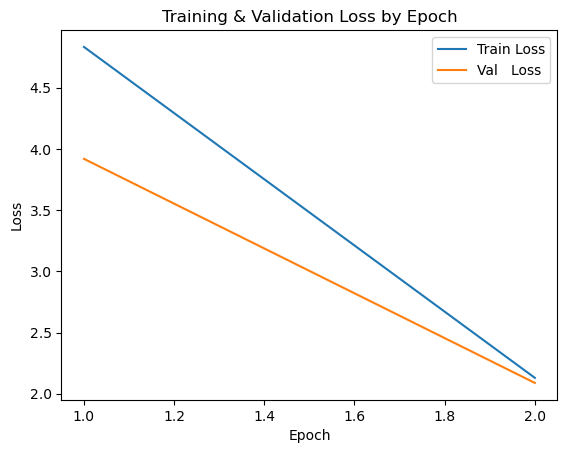

test: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[test] Epoch 2 – loss: 2.7921, P Acc: 0.000, N Acc: 0.000, Avg Acc: 0.000, F1: 0.000
Test F1-score on best model: 0.000
Saved best‐F1 checkpoint to data/data/train_results/siamese_contrastive_test-f1=0.000_splitting-by-query_cc12m_rubert_tiny_ep_1.pt.pt


In [ ]:
from torch.utils.data import DataLoader

def _run():
    images_dir = os.path.join(DATA_PATH, IMG_DATASET_NAME)

    # 1) Prepare splits and rename columns
    splits = {
        'train':      actual_train_df,
        'validation': actual_val_df,
        'test':       actual_test_df,
    }
    loaders = {}

    for split_name, df in splits.items():
        # build dataset + loader
        labels = df["label"].values
        ds     = SiameseRuCLIPDataset(df.drop(columns="label"), labels, images_dir=images_dir)

        shuffle = (split_name == 'train')
        loaders[split_name] = DataLoader(
            ds,
            batch_size=BATCH_SIZE,
            shuffle=shuffle,
            num_workers=NUM_WORKERS
        )

    train_loader = loaders['train']
    valid_loader = loaders['validation']
    test_loader  = loaders['test']

    print("Loading model and optimizer…")
    model     = SiameseRuCLIP(
        DEVICE, NAME_MODEL_NAME,
        DESCRIPTION_MODEL_NAME,
        PRELOAD_MODEL_NAME,
        DATA_PATH + RESULTS_DIR,
    ).to(DEVICE)

    criterion = ContrastiveLoss(margin=CONTRASTIVE_MARGIN).to(DEVICE)
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY
    )
    print("Done.")

    # Temporary dir for intermediate checkpoints
    with tempfile.TemporaryDirectory() as tmp_ckpt_dir:
        train_losses, val_losses, best_f1, best_weights = train(
            model, optimizer, criterion,
            EPOCHS, train_loader, valid_loader,
            print_epoch=True,
            device=DEVICE,
            models_dir=tmp_ckpt_dir
        )
    print(f"→ Best validation F1: {best_f1:.3f}")

    # Plot train vs. val loss by epoch
    epochs = list(range(1, len(train_losses) + 1))
    fig, ax = plt.subplots()
    ax.plot(epochs, train_losses, label='Train Loss')
    ax.plot(epochs, val_losses,   label='Val   Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training & Validation Loss by Epoch')
    ax.legend()
    if MLFLOW_URI:
        mlflow.log_figure(fig, 'loss_by_epoch.png')

    # TODO: display after each train epoch
    display.clear_output(wait=True)
    display.display(fig)
    plt.close(fig)


    # Final test on the best model
    model.load_state_dict(best_weights)
    model.eval()
    test_pos_acc, test_neg_acc, test_acc, test_f1, test_loss = validation(
        model, criterion, test_loader,
        epoch=EPOCHS, device=DEVICE, split_name='test'
    )
    print(f"Test F1-score on best model: {test_f1:.3f}")

    # Save only final model
    filename = (
        f"siamese_contrastive_test-f1={test_f1:.3f}"
        f"{'_' + MODEL_NAME_POSTFIX if MODEL_NAME_POSTFIX else ''}"
        f"{'_' + PRELOAD_MODEL_NAME if PRELOAD_MODEL_NAME else ''}"
        ".pt"
    )

    final_path = (
        Path(DATA_PATH + RESULTS_DIR) /
        filename
    )

    final_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(best_weights, final_path)
    print(f"Saved best‐F1 checkpoint to {final_path}")

    if MLFLOW_URI:
        mlflow.log_metric("test_pos_accuracy", test_pos_acc)
        mlflow.log_metric("test_neg_accuracy", test_neg_acc)
        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("test_f1_score", test_f1)
        mlflow.end_run()

_run()